In [ ]:
import torch, tqdm
from kme.models.utils import build_kme_net
from kme.tools.config import load_config, DATASET_KEY, TRAINING_KEY, MODEL_KEY, CKPT_KEY
from kme.tools.checkpoint import load_checkpoint, save_checkpoint
from kme.data.utils import get_loaders
import torch.optim as optim
from kme.tools.training import train_routine, test_routine
from sklearn.neighbors import KDTree
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Unfold, Fold
import seaborn as sns
import captum
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
MNIST_CONFIG_FPATH = '/home/phineas/Documents/repos/kme_net/results/mnist/4/kmenet_sample_config.json'
SVHN_CONFIG_FPATH = '/home/phineas/Documents/repos/kme_net/results/mnist/5/kmenet_sample_config.json'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# MNIST loading
config = load_config(MNIST_CONFIG_FPATH)

dataset_params = config[DATASET_KEY]
training_params = config[TRAINING_KEY]
model_params = config[MODEL_KEY]
ckpt_root = config[CKPT_KEY]

# training params
N_EPOCHS = training_params['n_epochs']
BATCH_SIZE = 1000
OPTIMIZER = training_params['optimizer']
OPTIMIZER_PARAMS = training_params['optimizer_params']
SCHEDULER = training_params['scheduler']

dataset_params = config[DATASET_KEY]
mnist_train_loader, mnist_valid_loader, mnist_test_loader = get_loaders(**dataset_params, batch_size=BATCH_SIZE)
mnist_kme_net = build_kme_net(model_params, device=device).to(device)

optimizer = getattr(optim, OPTIMIZER)(mnist_kme_net.parameters(), **OPTIMIZER_PARAMS)
scheduler = None
if SCHEDULER is not None:
    SCHEDULER_PARAMS = training_params['scheduler_params']
    scheduler = getattr(optim.lr_scheduler, SCHEDULER)(optimizer, **SCHEDULER_PARAMS)

# checkpoint and summary writer
mnist_kme_net, optimizer, scheduler, epoch = load_checkpoint(ckpt_root, mnist_kme_net, optimizer, scheduler)

In [4]:
# SVHN loading
config = load_config(SVHN_CONFIG_FPATH)

dataset_params = config[DATASET_KEY]
training_params = config[TRAINING_KEY]
model_params = config[MODEL_KEY]
ckpt_root = config[CKPT_KEY]

# training params
N_EPOCHS = training_params['n_epochs']
BATCH_SIZE = 200
OPTIMIZER = training_params['optimizer']
OPTIMIZER_PARAMS = training_params['optimizer_params']
SCHEDULER = training_params['scheduler']

dataset_params = config[DATASET_KEY]
svhn_train_loader, svhn_valid_loader, svhn_test_loader = get_loaders(**dataset_params, batch_size=BATCH_SIZE)
svhn_kme_net = build_kme_net(model_params, device=device).to(device)

optimizer = getattr(optim, OPTIMIZER)(svhn_kme_net.parameters(), **OPTIMIZER_PARAMS)
scheduler = None
if SCHEDULER is not None:
    SCHEDULER_PARAMS = training_params['scheduler_params']
    scheduler = getattr(optim.lr_scheduler, SCHEDULER)(optimizer, **SCHEDULER_PARAMS)

# checkpoint and summary writer
svhn_kme_net, optimizer, scheduler, epoch = load_checkpoint(ckpt_root, svhn_kme_net, optimizer, scheduler)

Using downloaded and verified file: /home/phineas/Documents/repos/kme_net/data/train_32x32.mat


In [5]:
# get train samples and patches representations
mnist_kme_net.eval()
for (mnist_imgs, mnist_ys) in tqdm.tqdm(mnist_test_loader):
    mnist_imgs_numpy = mnist_imgs.detach().numpy()
    mnist_patch_representations = mnist_kme_net._feat_net.process_samples(mnist_imgs)
    break
mnist_patch_representations_numpy = mnist_patch_representations.detach().numpy()
mnist_sample_representations = np.sum(mnist_patch_representations_numpy, axis=1)

  0%|          | 0/10 [00:01<?, ?it/s]


In [6]:
mnist_kdtree = KDTree(mnist_sample_representations, leaf_size=40)

In [7]:
# get train samples and patches representations
svhn_kme_net.eval()
for (svhn_imgs, svhn_ys) in tqdm.tqdm(svhn_test_loader):
    svhn_imgs_numpy = svhn_imgs.detach().numpy()
    svhn_patch_representations = svhn_kme_net._feat_net.process_samples(svhn_imgs)
    break
svhn_patch_representations_numpy = svhn_patch_representations.detach().numpy()
svhn_sample_representations = np.sum(svhn_patch_representations_numpy, axis=1)

  0%|          | 0/74 [00:02<?, ?it/s]


In [8]:
svhn_kdtree = KDTree(svhn_sample_representations, leaf_size=40)

In [9]:
print(torch.mean((svhn_kme_net._classifier(torch.FloatTensor(mnist_sample_representations)).argmax(dim=1) == mnist_ys).float()))

tensor(0.8860)


In [10]:
print(torch.mean((mnist_kme_net._classifier(torch.FloatTensor(svhn_sample_representations)).argmax(dim=1) == svhn_ys).float()))

tensor(0.8000)


In [11]:
TARGET = 4

valid_mnist_idx = np.where(mnist_ys == TARGET)
valid_svhn_idx = np.where(svhn_ys == TARGET)

In [12]:
print(valid_mnist_idx)
print(valid_svhn_idx)

(array([  4,   6,  19,  24,  27,  33,  42,  48,  49,  56,  65,  67,  85,
        95, 103, 109, 115, 116, 117, 121, 139, 159, 160, 163, 166, 169,
       170, 198, 210, 227, 238, 247, 248, 250, 275, 287, 295, 300, 304,
       308, 325, 360, 376, 379, 398, 399, 405, 420, 425, 428, 432, 447,
       475, 484, 497, 511, 519, 532, 533, 535, 541, 544, 555, 556, 565,
       571, 589, 610, 622, 660, 668, 670, 697, 698, 707, 708, 712, 719,
       722, 736, 740, 748, 752, 757, 760, 762, 765, 770, 774, 776, 784,
       789, 802, 803, 827, 829, 838, 843, 881, 901, 902, 908, 910, 916,
       931, 953, 959, 968, 969, 971]),)
(array([ 10,  17,  22,  29,  36,  45,  56,  68,  87,  96, 100, 114, 116,
       128, 130, 134, 139, 141, 159, 173, 185, 188, 189, 199]),)


In [13]:
def fold_img(patches, img_sz, pt_sz):
    n_batches = len(patches)
    fold = Fold(img_sz, pt_sz, padding=0, stride=pt_sz)
    patches = patches.reshape(n_batches, (img_sz//pt_sz)**2, pt_sz**2).transpose(1, 2)
    img = fold(patches)
    return img

In [14]:
MNIST_IDX = 22
SVHN_IDX = 10

/home/phineas/anaconda3/envs/kme_net/lib/python3.6/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


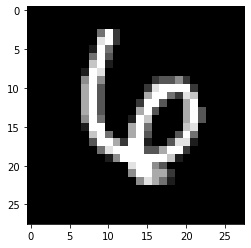

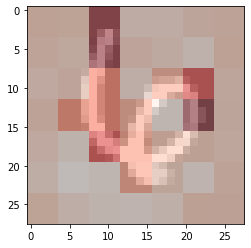

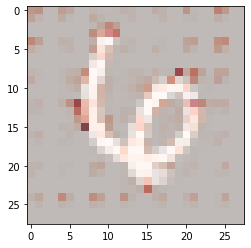

In [15]:
mnist_norms = np.linalg.norm(mnist_patch_representations_numpy[MNIST_IDX], axis=1)
mnist_normalized_norms = mnist_norms/np.max(mnist_norms)
mnist_ordered_norms = mnist_normalized_norms.argsort()[::-1]
mnist_importance_patches = np.zeros((1,49, 16))
for i in mnist_ordered_norms:
    mnist_importance_patches[0, i, :] = mnist_normalized_norms[i]
fold = Fold((28, 28), (4, 4), padding=0, stride=4)
mnist_importance_patches = torch.FloatTensor(mnist_importance_patches).transpose(1,2)
curr_img = fold(mnist_importance_patches)[0].detach().numpy()

def attribute_image_features(algorithm, input, **kwargs):
    mnist_kme_net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=mnist_kme_net(input).argmax(),
                                              **kwargs
                                             )
    return tensor_attributions

input = mnist_imgs[MNIST_IDX:MNIST_IDX+1]

ig = Saliency(mnist_kme_net)
attr_ig = attribute_image_features(ig, input)
attr_ig = attr_ig.squeeze().cpu().detach().numpy()

plt.figure(1)
plt.imshow(mnist_imgs_numpy[MNIST_IDX, 0], cmap='gray')

plt.figure(2)
plt.imshow(mnist_imgs_numpy[MNIST_IDX, 0], cmap='gray', alpha=0.5)
plt.imshow(curr_img[0], cmap='Reds', alpha=0.5)

plt.figure(3)
plt.imshow(mnist_imgs_numpy[MNIST_IDX, 0], cmap='gray', alpha=0.5)
plt.imshow(attr_ig, cmap='Reds', alpha=0.5)

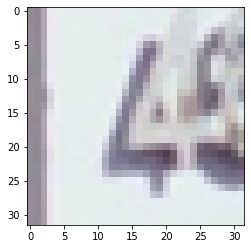

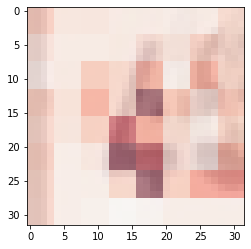

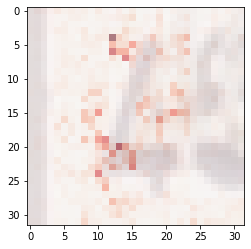

In [16]:
svhn_norms = np.linalg.norm(svhn_patch_representations_numpy[SVHN_IDX], axis=1)
svhn_normalized_norms = svhn_norms/np.max(svhn_norms)
svhn_ordered_norms = svhn_normalized_norms.argsort()[::-1]
svhn_importance_patches = np.zeros((1,64, 16))
for i in svhn_ordered_norms:
    svhn_importance_patches[0, i, :] = svhn_normalized_norms[i]
fold = Fold((32, 32), (4, 4), padding=0, stride=4)
svhn_importance_patches = torch.FloatTensor(svhn_importance_patches).transpose(1,2)
curr_img = fold(svhn_importance_patches)[0].detach().numpy()

def attribute_image_features(algorithm, input, **kwargs):
    svhn_kme_net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=svhn_kme_net(input).argmax(),
                                              **kwargs
                                             )
    return tensor_attributions

input = svhn_imgs[SVHN_IDX:SVHN_IDX+1]

ig = Saliency(svhn_kme_net)
attr_ig = attribute_image_features(ig, input)
attr_ig = attr_ig.squeeze().cpu().detach().numpy()

plt.figure(1)
plt.imshow(np.transpose(svhn_imgs_numpy[SVHN_IDX], (1, 2, 0)))

plt.figure(2)
plt.imshow(np.transpose(svhn_imgs_numpy[SVHN_IDX], (1, 2, 0)), cmap='gray', alpha=0.5)
plt.imshow(curr_img[0], cmap='Reds', alpha=0.5)

plt.figure(3)
plt.imshow(np.transpose(svhn_imgs_numpy[SVHN_IDX], (1, 2, 0)), cmap='gray', alpha=0.5)
plt.imshow(np.linalg.norm(attr_ig, axis=0), cmap='Reds', alpha=0.5)

tensor(0)
tensor(4)
[[255.35265268]]


<Figure size 432x288 with 0 Axes>

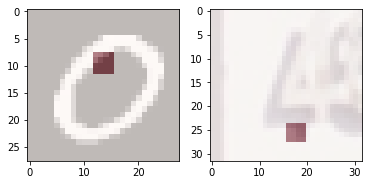

<Figure size 432x288 with 0 Axes>

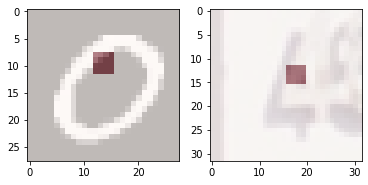

<Figure size 432x288 with 0 Axes>

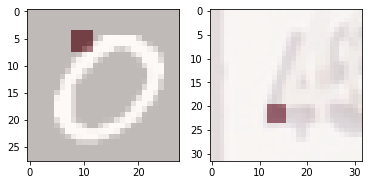

<Figure size 432x288 with 0 Axes>

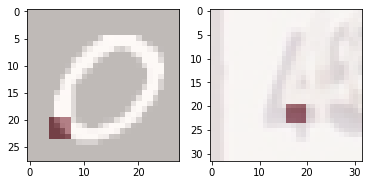

<Figure size 432x288 with 0 Axes>

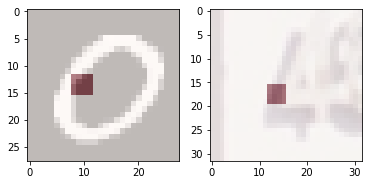

<Figure size 432x288 with 0 Axes>

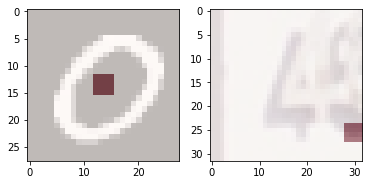

<Figure size 432x288 with 0 Axes>

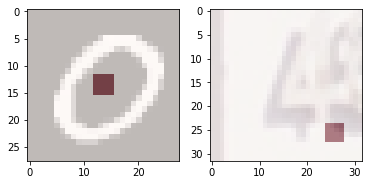

<Figure size 432x288 with 0 Axes>

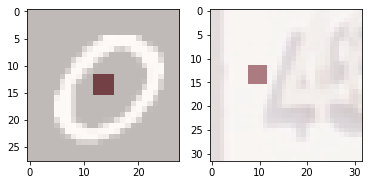

<Figure size 432x288 with 0 Axes>

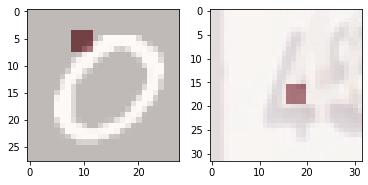

<Figure size 432x288 with 0 Axes>

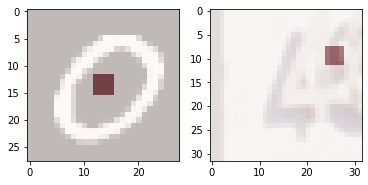

In [17]:
dists, ind = mnist_kdtree.query(svhn_sample_representations[SVHN_IDX:SVHN_IDX+1], 1)
OTHER_IDX = ind[0, 0]
mnist_ref_img = mnist_imgs[OTHER_IDX:OTHER_IDX+1]
svhn_ref_img = svhn_imgs[SVHN_IDX:SVHN_IDX+1]

print(mnist_kme_net._classifier(torch.FloatTensor(mnist_sample_representations[OTHER_IDX:OTHER_IDX+1])).argmax())
print(svhn_kme_net._classifier(torch.FloatTensor(svhn_sample_representations[SVHN_IDX:SVHN_IDX+1])).argmax())
print(dists)

for i in svhn_ordered_norms[:10]:
    hm_mnist = torch.zeros((1, 49, 1, 4, 4))
    hm_svhn = torch.zeros((1, 64, 1, 4, 4))
    
    hm_svhn[0, i, 0, :, :] = 1.0
    
    curr_patch_repr = svhn_patch_representations_numpy[SVHN_IDX, i]
    
    diffs = np.linalg.norm(mnist_patch_representations_numpy[OTHER_IDX] - curr_patch_repr, axis=1)
    closest_patch = np.argmin(diffs)
    hm_mnist[0, closest_patch, 0, :, :] = 1.0
    
    plt.figure(i+1)
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(mnist_ref_img[0,0].detach().numpy(), cmap='gray', alpha=0.5)
    axis[0].imshow(fold_img(hm_mnist, 28, 4)[0,0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    
    axis[1].imshow(svhn_ref_img[0].transpose(0, 1).transpose(1, 2).detach().numpy(), alpha=0.5)
    axis[1].imshow(fold_img(hm_svhn, 32, 4)[0, 0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    plt.show()

tensor(6)
tensor(8)
[[232.84205264]]


<Figure size 432x288 with 0 Axes>

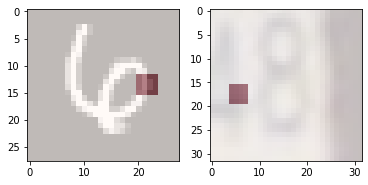

<Figure size 432x288 with 0 Axes>

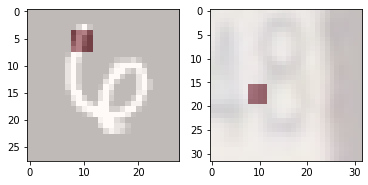

<Figure size 432x288 with 0 Axes>

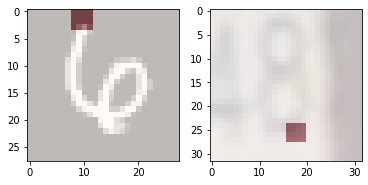

<Figure size 432x288 with 0 Axes>

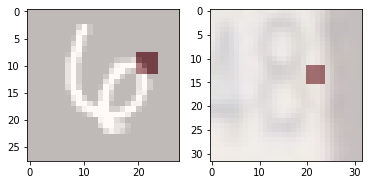

<Figure size 432x288 with 0 Axes>

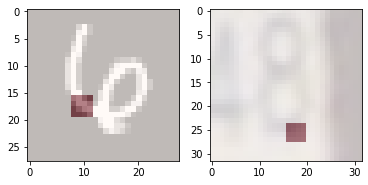

<Figure size 432x288 with 0 Axes>

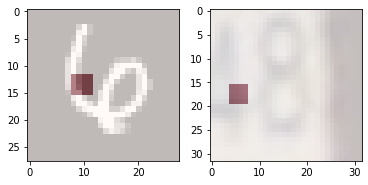

<Figure size 432x288 with 0 Axes>

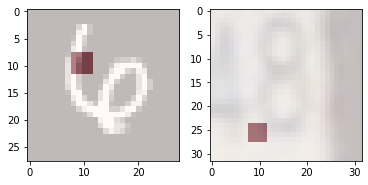

<Figure size 432x288 with 0 Axes>

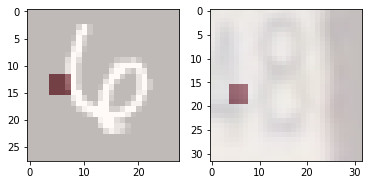

<Figure size 432x288 with 0 Axes>

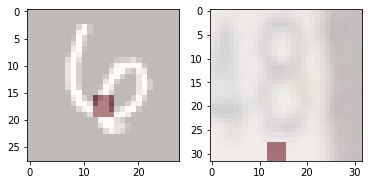

<Figure size 432x288 with 0 Axes>

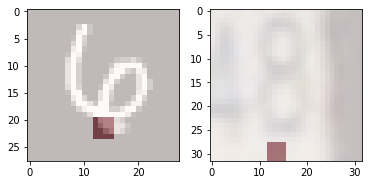

In [18]:
dists, ind = svhn_kdtree.query(mnist_sample_representations[MNIST_IDX:MNIST_IDX+1], 1)
OTHER_IDX = ind[0, 0]
mnist_ref_img = mnist_imgs[MNIST_IDX:MNIST_IDX+1]
svhn_ref_img = svhn_imgs[OTHER_IDX:OTHER_IDX+1]

print(mnist_kme_net._classifier(torch.FloatTensor(mnist_sample_representations[MNIST_IDX:MNIST_IDX+1])).argmax())
print(svhn_kme_net._classifier(torch.FloatTensor(svhn_sample_representations[OTHER_IDX:OTHER_IDX+1])).argmax())
print(dists)

for i in mnist_ordered_norms[:10]:
    hm_mnist = torch.zeros((1, 49, 1, 4, 4))
    hm_svhn = torch.zeros((1, 64, 1, 4, 4))
    
    hm_mnist[0, i, 0, :, :] = 1.0
    
    curr_patch_repr = mnist_patch_representations_numpy[MNIST_IDX, i]
    
    diffs = np.linalg.norm(svhn_patch_representations_numpy[OTHER_IDX] - curr_patch_repr, axis=1)
    closest_patch = np.argmin(diffs)
    hm_svhn[0, closest_patch, 0, :, :] = 1.0
    
    plt.figure(i+1)
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(mnist_ref_img[0,0].detach().numpy(), cmap='gray', alpha=0.5)
    axis[0].imshow(fold_img(hm_mnist, 28, 4)[0,0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    
    axis[1].imshow(svhn_ref_img[0].transpose(0, 1).transpose(1, 2).detach().numpy(), alpha=0.5)
    axis[1].imshow(fold_img(hm_svhn, 32, 4)[0, 0].detach().numpy(), cmap='Reds', alpha=0.5)
    
    plt.show()